# Implementing a transformer for time-series forecasting

https://towardsdatascience.com/how-to-make-a-pytorch-transformer-for-time-series-forecasting-69e073d4061e

In [16]:
"""
Showing how to use the model with some time series data.

NB! This is not a full training loop. You have to write the training loop yourself. 

I.e. this code is just a starting point to show you how to initialize the model and provide its inputs

If you do not know how to train a PyTorch model, it is too soon for you to dive into transformers imo :) 

You're better off starting off with some simpler architectures, e.g. a simple feed forward network, in order to learn the basics
"""

import dataset as ds
import utils
from torch.utils.data import DataLoader
import torch
import datetime
import transformer_timeseries as tst
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparams
test_size = 0.1
batch_size = 128
target_col_name = "FCR_N_PriceEUR"
timestamp_col = "timestamp"
# Only use data from this date and onwards
cutoff_date = datetime.datetime(2017, 1, 1) 

## Params
dim_val = 128
n_heads = 8
n_decoder_layers = 2
n_encoder_layers = 2
dec_seq_len = 92 # length of input given to decoder
enc_seq_len = 168 # length of input given to encoder
output_sequence_length = 48 # target sequence length. If hourly data and length = 48, you predict 2 days ahead
window_size = enc_seq_len + output_sequence_length # used to slice data into sub-sequences
step_size = 1 # Step size, i.e. how many time steps does the moving window move at each step
in_features_encoder_linear_layer = 2048
in_features_decoder_linear_layer = 2048
max_seq_len = enc_seq_len
batch_first = False

# Define input variables 
exogenous_vars = [] # should contain strings. Each string must correspond to a column name
input_variables = [target_col_name] + exogenous_vars
target_idx = 0 # index position of target in batched trg_y

input_size = len(input_variables)

# Read data
data = utils.read_data(timestamp_col_name=timestamp_col)

# Slice training and test data
training_data = data[:-(round(len(data)*test_size))]
test_data = data[-(round(len(data)*test_size)):]

# Make list of (start_idx, end_idx) pairs that are used to slice the time series sequence into chunks. 
# Should be training data indices only
training_indices = utils.get_indices_entire_sequence(
    data=training_data, 
    window_size=window_size, 
    step_size=step_size
)

# Making instance of custom dataset class
training_data = ds.TransformerDataset(
    data=torch.tensor(training_data[input_variables].values).float(),
    indices=training_indices,
    enc_seq_len=enc_seq_len,
    dec_seq_len=dec_seq_len,
    target_seq_len=output_sequence_length
)

# Making dataloader
training_dataloader = DataLoader(training_data, batch_size)

# Validation data
validation_indices = utils.get_indices_entire_sequence(
    data=test_data, 
    window_size=window_size, 
    step_size=step_size
)

validation_data = ds.TransformerDataset(
    data=torch.tensor(test_data[input_variables].values).float(),
    indices=validation_indices,
    enc_seq_len=enc_seq_len,
    dec_seq_len=dec_seq_len,
    target_seq_len=output_sequence_length
)

validation_dataloader = DataLoader(validation_data, batch_size)

i, batch = next(enumerate(training_dataloader))

src, trg, trg_y = batch

# Permute from shape [batch size, seq len, num features] to [seq len, batch size, num features]
if batch_first == False:

    shape_before = src.shape
    src = src.permute(1, 0, 2).to(device)
    print("src shape changed from {} to {}".format(shape_before, src.shape))

    shape_before = trg.shape
    trg = trg.permute(1, 0, 2).to(device)
    print("trg shape changed from {} to {}".format(shape_before, trg.shape))

model = tst.TimeSeriesTransformer(
    input_size=len(input_variables),
    dec_seq_len=enc_seq_len,
    batch_first=batch_first,
    num_predicted_features=1
).to(device)

print('Loaded model to GPU.')

# Make src mask for decoder with size:
# [batch_size*n_heads, output_sequence_length, enc_seq_len]
'''src_mask = utils.generate_square_subsequent_mask(
    dim1=output_sequence_length,
    dim2=enc_seq_len
)#.to(device)

# Make tgt mask for decoder with size:
# [batch_size*n_heads, output_sequence_length, output_sequence_length]
tgt_mask = utils.generate_square_subsequent_mask( 
    dim1=output_sequence_length,
    dim2=output_sequence_length
)#.to(device)

output = model(
    src=src,
    tgt=trg,
    src_mask=src_mask,
    tgt_mask=tgt_mask
)'''


Reading file in data/dfs_merged_upload.csv
From get_src_trg: data size = torch.Size([41387, 1])
From get_src_trg: data size = torch.Size([4598, 1])
src shape: torch.Size([128, 168, 1])
trg shape: torch.Size([128, 48, 1])
trg_y shape: torch.Size([128, 48])
src shape changed from torch.Size([128, 168, 1]) to torch.Size([168, 128, 1])
trg shape changed from torch.Size([128, 48, 1]) to torch.Size([48, 128, 1])
Loaded model to GPU.


'src_mask = utils.generate_square_subsequent_mask(\n    dim1=output_sequence_length,\n    dim2=enc_seq_len\n)#.to(device)\n\n# Make tgt mask for decoder with size:\n# [batch_size*n_heads, output_sequence_length, output_sequence_length]\ntgt_mask = utils.generate_square_subsequent_mask( \n    dim1=output_sequence_length,\n    dim2=output_sequence_length\n)#.to(device)\n\noutput = model(\n    src=src,\n    tgt=trg,\n    src_mask=src_mask,\n    tgt_mask=tgt_mask\n)'

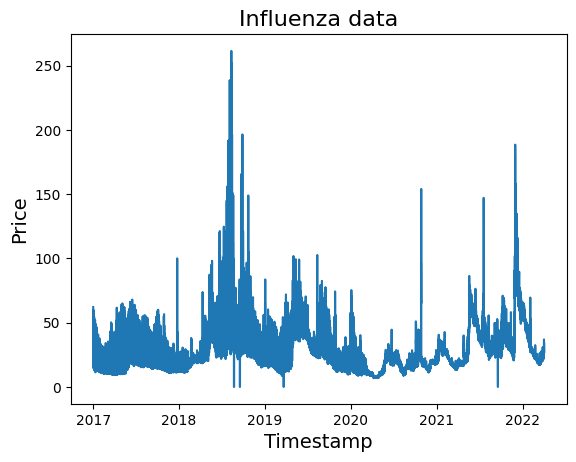

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_data(data, target_col_name="FCR_N_PriceEUR"):
    plt.title("Influenza data", fontsize=16)
    plt.xlabel("Timestamp", fontsize=14)
    plt.ylabel("Price", fontsize=14)
    plt.plot(data[target_col_name])
    plt.show()

plot_data(data)

In [13]:
# DataFrame concat test

df1 = pd.DataFrame()
df2 = pd.DataFrame({"a": [7, 8, 9], "b": [10, 11, 12]})

df3 = pd.concat([df1, df2], axis=0)
print(df3)

Empty DataFrame
Columns: []
Index: []


In [17]:
"""
Pseudo code-ish example of how to use the inference function to do validation
during training. 

The validation loop can be used as-is for model testing as well.

NB! You cannot use this script as is. This is merely an example to show the overall idea - 
not something you can copy paste and expect to work. For instance, see "sandbox.py" 
for example of how to instantiate model and generate dataloaders.

If you have never before trained a PyTorch neural network, I suggest you look
at some of PyTorch's beginner-level tutorials.
"""
import torch
import inference
import utils
import pandas as pd

torch.cuda.empty_cache()

epochs = 5

forecast_window = 48 # supposing you're forecasting 48 hours ahead

enc_seq_len = 168 # supposing you want the model to base its forecasts on the previous 7 days of data

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

criterion = torch.nn.MSELoss()

training_dataloader = DataLoader(training_data, batch_size)

# Generate masks
tgt_mask = utils.generate_square_subsequent_mask(
    dim1=forecast_window,
    dim2=forecast_window,
    device=device
)
src_mask = utils.generate_square_subsequent_mask(
    dim1=forecast_window,
    dim2=enc_seq_len,
    device=device
)

# panda dataframe to store train and validation losses
train_losses = pd.DataFrame()
validation_losses = pd.DataFrame()

# Iterate over all epochs
for epoch in range(epochs):
	# Iterate over all (x,y) pairs in training dataloader
    for i, (src, tgt, tgt_y) in enumerate(training_dataloader):
	
        if batch_first == False:
            src = src.permute(1, 0, 2).to(device)
            tgt = tgt.permute(1, 0, 2).to(device)
            tgt_y = tgt_y.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # Make forecasts
        prediction = model(src, tgt, src_mask, tgt_mask)

        # Compute and backprop loss
        loss = criterion(tgt_y, prediction.squeeze().T)
        
        loss.backward()

        # Take optimizer step
        optimizer.step()

        train_losses = pd.concat([train_losses, pd.DataFrame({'epoch': [epoch], 'batch': [i], 'loss': [loss.item()]})], axis=0)
        if i % 50 == 0:
            print("Epoch {} batch {} loss: {}".format(epoch, i, loss.item()))
    
    print("Epoch {} finished, loss: {}".format(epoch, loss.item()))
    
    # Iterate over all (x,y) pairs in validation dataloader
    model.eval()
    
    with torch.no_grad():
        for i, (src, _, tgt_y) in enumerate(validation_dataloader):
            if batch_first == False:
                src = src.permute(1, 0, 2).to(device)
                tgt_y = tgt_y.to(device)
            
            prediction = inference.run_encoder_decoder_inference(
                model=model, 
                src=src, 
                forecast_window=forecast_window,
                batch_size=src.shape[1],
                device=device
                )
            
            loss = criterion(tgt_y, prediction.squeeze().T)

            print("Validation loss: {}".format(loss.item()))
            validation_losses = pd.concat([validation_losses, pd.DataFrame({'epoch': [epoch], 'batch': [i], 'loss': [loss.item()]})], axis=0)

Epoch 0 batch 0 loss: 661.3363037109375
Epoch 0 batch 50 loss: 272.6404724121094
Epoch 0 batch 100 loss: 605.38330078125
Epoch 0 batch 150 loss: 255.9384765625
Epoch 0 batch 200 loss: 86.91510009765625
Epoch 0 batch 250 loss: 15.966094970703125
Epoch 0 batch 300 loss: 1574.3359375
Epoch 0 finished, loss: 291.5033264160156
Validation loss: 170.470458984375
Validation loss: 140.40191650390625
Validation loss: 139.5846710205078
Validation loss: 46.941612243652344
Validation loss: 88.51161193847656
Validation loss: 74.67450714111328
Validation loss: 99.2021713256836
Validation loss: 96.20767211914062
Validation loss: 185.0208740234375
Validation loss: 377.645751953125
Validation loss: 376.1211853027344
Validation loss: 5588.65966796875
Validation loss: 2823.26708984375
Validation loss: 1683.8836669921875
Validation loss: 634.5684814453125
Validation loss: 325.52117919921875
Validation loss: 193.40155029296875
Validation loss: 167.0965576171875
Validation loss: 143.76683044433594
Validation

In [25]:
# add index to train and validation losses
train_losses = train_losses.reset_index(drop=True)
validation_losses = validation_losses.reset_index(drop=True)

Empty DataFrame
Columns: []
Index: []


KeyError: 'loss'

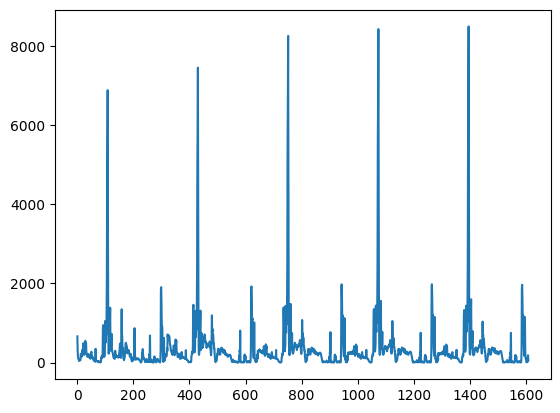

In [28]:
# Plot train losses by batch
import matplotlib.pyplot as plt
print(validation_losses)
plt.plot(train_losses.index, train_losses['loss'], label='train loss')
plt.plot(validation_losses.index, validation_losses['loss'], label='validation loss')

In [13]:
# create tensor of shape (48, 128, 1)

t = torch.rand(48, 128, 1)
print(t.shape)

# reshape to (48, 128) by removing the last dimension

t = t.squeeze()
print(t.T.shape)

torch.Size([48, 128, 1])
torch.Size([128, 48])


In [7]:
print(torch.cuda.get_device_name(0))
print(torch.cuda.memory_allocated(0))
print(torch.cuda.memory_reserved(0))
torch.cuda.empty_cache()

NVIDIA GeForce RTX 3070
12185566208
12253659136


In [9]:
print(model.parameters())

<generator object Module.parameters at 0x7f33e1b47610>


In [ ]:
import time
import copy

lr = 5.0
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

def train(model: torch.nn.Module) -> None:
    model.train()  # turn on train mode
    total_loss = 0.
    log_interval = 200
    start_time = time.time()
    src_mask = utils.generate_square_subsequent_mask(
            dim1=forecast_window,
            dim2=enc_seq_len
            )

    num_batches = len(train_data) // bptt
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        seq_len = data.size(0)
        if seq_len != bptt:  # only on last batch
            src_mask = src_mask[:seq_len, :seq_len]
        output = model(data, src_mask)
        loss = criterion(output.view(-1, ntokens), targets)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        if batch % log_interval == 0 and batch > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            ppl = math.exp(cur_loss)
            print(f'| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | '
                  f'lr {lr:02.2f} | ms/batch {ms_per_batch:5.2f} | '
                  f'loss {cur_loss:5.2f} | ppl {ppl:8.2f}')
            total_loss = 0
            start_time = time.time()

def evaluate(model: nn.Module, eval_data: Tensor) -> float:
    model.eval()  # turn on evaluation mode
    total_loss = 0.
    src_mask = generate_square_subsequent_mask(bptt).to(device)
    with torch.no_grad():
        for i in range(0, eval_data.size(0) - 1, bptt):
            data, targets = get_batch(eval_data, i)
            seq_len = data.size(0)
            if seq_len != bptt:
                src_mask = src_mask[:seq_len, :seq_len]
            output = model(data, src_mask)
            output_flat = output.view(-1, ntokens)
            total_loss += seq_len * criterion(output_flat, targets).item()
    return total_loss / (len(eval_data) - 1)